# Visual search with k-NN

This is the third notebook of this project.


## Build X and y vectors

In this Notebook, as well as in the other Notebooks, I will have to build X_train, X_valid, X_test, y_train, y_valid and y_test from the data. As this will have to be done several time, I will add it into *mylib.py* file as a library function.

> Note: The function build the three dataset (*train*, *valid* and *test*) and add a new one, *trainX*, which is a merge of *train* and *valid* dataset, to be used when cross validation is used by models.

The code is basic:

    def loadXy(data=None, concatenate=[]):
        """
        This function returns the data, an X and a y dict containing 'train', 'valid', 'test' and 'trainX' vectors
        from the data passed as parameter.
        The 'trainX' is the merge of the 'train' and 'valid' dataset.
        If the data parameter is set to None, this function uses the loadNpz() function with default parameter
        to get the data.
        Note that the data passed as parameter must comply with the structure passed in Notebook number 1
        """

        if data==None:
            data=loadNpz()

        X=dict()
        y=dict()
        # Get X_train from high level feateurs and y_train from labels
        for name in data['DATASET_NAME']:
            X[name]=data[name]['features']
            y[name]=data[name]['labels']
            print("X {} shape:".format(name),X[name].shape)
            print("y {} shape:".format(name),X[name].shape)

        X['trainX']=np.concatenate((X['train'], X['valid']), axis=0)
        y['trainX']=np.concatenate((y['train'], y['valid']), axis=0)
        print("X trainX shape:", X['trainX'].shape)
        print("y trainX shape:", X['trainX'].shape)

        return (data, X, y)

> Note: The code above might not be the latest one. Please check the content of *mylib.py* to get the most up to date algorythm

## Load X,y data from NPZ

Using the function added to *mylib.py* file, it's now easy to grab data and X/y vectors ready to be used for model training and tuning

In [1]:
# Run content of mylib.py file
%run mylib.py

# Load data from NPZ file
#data=loadNpz()
(data, X, y)=loadXy()

Loading 'train' set
  loading  data
     shape: (281, 299, 299, 3) - dtype: float64
  loading  features
     shape: (281, 2048) - dtype: float64
  loading  filenames
     shape: (281,) - dtype: <U46
  loading  labels
     shape: (281,) - dtype: int32


Loading 'test' set
  loading  data
     shape: (51, 299, 299, 3) - dtype: float64
  loading  features
     shape: (51, 2048) - dtype: float64
  loading  filenames
     shape: (51,) - dtype: <U50
  loading  labels
     shape: (51,) - dtype: int32


Loading 'valid' set
  loading  data
     shape: (139, 299, 299, 3) - dtype: float64
  loading  features
     shape: (139, 2048) - dtype: float64
  loading  filenames
     shape: (139,) - dtype: <U30
  loading  labels
     shape: (139,) - dtype: int32


building 'trainX' set
  building  data
     shape: (420, 299, 299, 3) - dtype: float64
  building  features
     shape: (420, 2048) - dtype: float64
  building  filenames
     shape: (420,) - dtype: <U46
  building  labels
     shape: (420,) - dt

## Fit and tune a k-NN classifier

### Fit a basic k-NN classifier

For this first try at fitting a K-NN classifier, I've choosen to fix the number of neighbourts to the number of class image I have in my dataset. This is completly arbitrary, I could also choose 5 or 8, it doesn't matter at that time. Further in this Notebook, I'll do some tuning to find the most effective *n_neighbors* value for the K-NN classifier.

Same for the *scaler* and the *algorithm* parameter, I'll perfom some grid search on all of those parameters further in this Notebook. For now, let's use a StandardScaler and an algorithm='brute'

> Note: The following code has been taken from the course


In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

N_NEIGHBORS=len(data['class_name'])
ALGORITHM='brute'
SCALER=StandardScaler()

# Create k-NN classifier
knn = KNeighborsClassifier(
    n_neighbors=N_NEIGHBORS, # Set k to number of class we have in datasets
    # Use the simple 'brute' strategy to find nearest neighbors.
    # It's faster in this case!
    algorithm=ALGORITHM,
    n_jobs=-1
)

# Create the pipeline and fit it to training data
knn_pipe = Pipeline([
    ('scaler', SCALER), # With standardization
    ('knn', knn)
])

knn_pipe.fit(X['train'], y['train'])

# Evaluate on test set
accuracy = knn_pipe.score(X['valid'], y['valid'])

# Print accuracy
print('k-nearest neighbors (k={}) accuracy: {:.1f}%'.format(len(data['class_name']), accuracy*100))

k-nearest neighbors (k=6) accuracy: 92.8%


Hmmm, an accuracy of 92,8%, not so bad.

### Tune our model

Let's use GridSearchCV to tune our model.

I will perform some tuning with:
* n_neighbors
* algorithm
* scaler
* weights
* p (power parameter)

> Note 1: As GridSearchCV include K-Fold mecanism to randomly select train/valid data, I will use the concatenated version of the data, *trainX*.

> Note 2: I will use a cross validation parameter of 5 K-Fold

> Note 3: The following code has been taken from one of the exercise I've made during the course

In [3]:
from sklearn.model_selection import GridSearchCV

print('Train dataset shape: X={} / y={}'.format(X['trainX'].shape, y['trainX'].shape))


# Here are the different parameters I will vary
grid_param={
    'scaler': [None, StandardScaler()],
    'knn__n_neighbors': [1,2,5,10,15,20, 30, 50],
    'knn__weights': ['uniform','distance'],
    'knn__p': [1, 2],
    'knn__algorithm': ['ball_tree', 'kd_tree', 'brute']
}

# Build the GridSearchCV object using versbose and parallel execution options
grid_cv=GridSearchCV(knn_pipe, grid_param, cv=5, refit=True, return_train_score=True, verbose=True, n_jobs=-1, iid=True)


# grid_cv.get_params().keys()
# Fit the model
grid_cv.fit(X['trainX'], y['trainX'])


Train dataset shape: X=(420, 2048) / y=(420,)
Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   43.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'scaler': [None, StandardScaler(copy=True, with_mean=True, with_std=True)], 'knn__n_neighbors': [1, 2, 5, 10, 15, 20, 30, 50], 'knn__weights': ['uniform', 'distance'], 'knn__p': [1, 2], 'knn__algorithm': ['ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

Now that tuning is done, let's find the best parameters to be used.

In [4]:
import pandas as pd

# Display top 5 best test score
columns=[
    'param_scaler', 'param_knn__n_neighbors', 'param_knn__weights', 'param_knn__p',
    'param_knn__algorithm', 'mean_test_score', 'std_test_score', 'mean_train_score'
]
pd.DataFrame(grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[columns].head(10)

,param_scaler,param_knn__n_neighbors,param_knn__weights,param_knn__p,param_knn__algorithm,mean_test_score,std_test_score,mean_train_score
146,None,5,distance,1,brute,0.930952,0.026496,1.000000
80,None,5,uniform,1,kd_tree,0.930952,0.026496,0.957745
18,None,5,distance,1,ball_tree,0.930952,0.026496,1.000000
144,None,5,uniform,1,brute,0.930952,0.026496,0.957745
16,None,5,uniform,1,ball_tree,0.930952,0.026496,0.957745
82,None,5,distance,1,kd_tree,0.930952,0.026496,1.000000
81,"StandardScaler(copy=True, with_mean=True, with...",5,uniform,1,kd_tree,0.928571,0.036600,0.959520
17,"StandardScaler(copy=True, with_mean=True, with...",5,uniform,1,ball_tree,0.928571,0.036600,0.959520
83,"StandardScaler(copy=True, with_mean=True, with...",5,distance,1,kd_tree,0.928571,0.036600,1.000000
145,"StandardScaler(copy=True, with_mean=True, with...",5,uniform,1,brute,0.928571,0.036600,0.959520


What are the conclusion ?

* StandardScaler seems to have no effect, we can remove it's usage.
* Number of neighbors best value is 5, and p (power parameter) is 1.
* weights and algorithm seems to have no effect on the test score.
* weights set to 'distance' gives better performance on the train score.
* algorithm has no effect at all.

Let's re-evaluate the accuracy of our model using this new parameters, on the train dataset and the valid one.


In [5]:
N_NEIGHBORS=5
ALGORITHM='brute'
P=1
WEIGHTS='distance'

# Create k-NN classifier
knn = KNeighborsClassifier(
    n_neighbors=N_NEIGHBORS, # Set k to number of class we have in datasets
    # Use the simple 'brute' strategy to find nearest neighbors.
    # It's faster in this case!
    algorithm=ALGORITHM,
    p=P,
    weights=WEIGHTS,
    n_jobs=-1
)

# As we do not use scaler, then usage of a pipeline is useless
# Fit directly the model
knn.fit(X['train'], y['train'])

# Evaluate on test set
accuracy = knn.score(X['valid'], y['valid'])

# Print accuracy
print('k-nearest neighbors (k={}) accuracy: {:.1f}%'.format(len(data['class_name']), accuracy*100))

k-nearest neighbors (k=6) accuracy: 93.5%


Good, tuning has given some positive results, the accuracy using train/valid datasets is a bit better (93.5% instead of 92.8%)

## Pick an image from the test set and plot its 10 nearest neighbors from the train set

As recommended in the project subject, I had a look at the *KNeighborsClassifier.kneighbors()* method to find out the 10 nearest neighbors of an image from the test set.

This method expect an array of reference data (I will pass the image from test set I've choosen), the number of neighbors we are looking for and if we would like to have the distance value for each neighbors.

To build the test image feature, I will get the high-level feature array from the test dataset and, to pass the right structure to the *kneighbors()* method, I will reshape this high-level feature to a 2D array of shape (1, 2048)

> Note: I will re-fit the model using the 'trainX' dataset for better precision.

Image index selected: 43
Graphing test images, filename: truck/truck-0069.png
Graphing images from 'trainX' dataset, indices: [223 228 393 400 239 407 245 394 403 237]




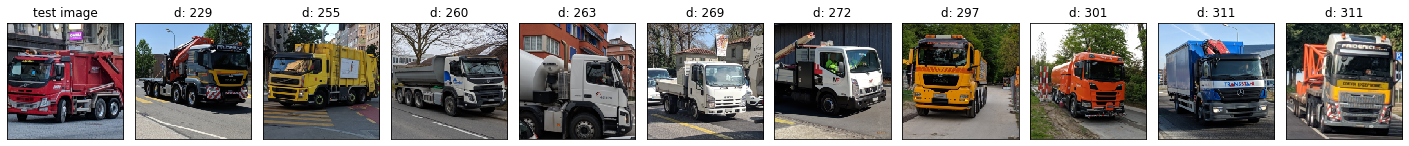

In [6]:
from random import randint
%matplotlib inline
import matplotlib.pyplot as plt

NEIGHBORS_NUMBERS=10

# Fit the 'trainX' dataset
knn.fit(X['trainX'], y['trainX'])

# Take a random picture feature from the test dataset
image_test_index=randint(0, len(X['test'])-1)
print("Image index selected:", image_test_index)

# Use reshape to get a 2D array
img_test_feature=np.reshape(X['test'][image_test_index], (-1, data['FEATURE_SIZE']))

# Use kneighbors() method to find neighbours of our test picture
(distances, indexes)=knn.kneighbors(X=img_test_feature, n_neighbors=NEIGHBORS_NUMBERS, return_distance=True)

# Plot the test image and the 10 nearest kneighbors
# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=NEIGHBORS_NUMBERS+1, figsize=(25, 10))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0.1, hspace=0)

axes[0].imshow(np.array(data['test']['data'][image_test_index]*255, dtype=np.uint8))
axes[0].get_xaxis().set_visible(False) # disable x-axis
axes[0].get_yaxis().set_visible(False) # disable y-axis
axes[0].set_title('test image')

print("Graphing test images, filename:", data['test']['filenames'][image_test_index])
print("Graphing images from 'trainX' dataset, indices:", indexes[0])
print("\n")

for i in range(0,NEIGHBORS_NUMBERS):
    axes[i+1].imshow(np.array(data['trainX']['data'][indexes[0][i]]*255, dtype=np.uint8))
    axes[i+1].get_xaxis().set_visible(False) # disable x-axis
    axes[i+1].get_yaxis().set_visible(False) # disable y-axis
    axes[i+1].set_title('d: {:.0f}'.format(distances[0][i]))
plt.show()

To visually verify the files found as neighbours, here are the filenames:

> Note: *trainx* subfolder does not exists, it's a combination of files from *train* and *valid* folder

In [7]:
print("Filenames of the neighbors found")
for i in indexes[0]:
    print('  - {}/{}'.format('trainX', data['trainX']['filenames'][i]))

Filenames of the neighbors found
  - trainX/truck/truck-0010.png
  - trainX/truck/truck-0015.png
  - trainX/truck/truck-0049.png
  - trainX/truck/truck-0056.png
  - trainX/truck/truck-0026.png
  - trainX/truck/truck-0063.png
  - trainX/truck/truck-0032.png
  - trainX/truck/truck-0050.png
  - trainX/truck/truck-0059.png
  - trainX/truck/truck-0024.png


That's it. K-NN classifer done ;-)

## Save the model

At the end of the project, we will have to compare the accuracy of the different models we will develop in the different Notebooks.

To simplify the work, and avoiding to manually report values from Notebooks to the last one, I've decided to save the models on disk, and I'll resuse them at the end of this project to check their accuracy.

To do so, I've added three new functions to *mylib.py*:

* getModelFilename(), in charge of building a standardized model based on its name
* saveModel(), a function that saves the model on disk
* loadModel(), a function that returns the model loaded from disk. 

    import pickle

    def getModelFilename(model_name):
        """
        Basic function that will return the filename used to store on disk the model
        passed as parameter
        """
        return 'model-{}.sav'.format(model_name)

    def saveModel(model, name):
        """
        Function that saves on disk the model passed as first parameter.
        It uses the function getModelFilename() with the 'name' parameter
        to get the filename where to save the model
        """
        filename=getModelFilename(name)
        # Save model to disk
        pickle.dump(model, open(filename, 'wb'))

    def loadModel(name):
        """
        Function that loads from disk the model of which name is passed as first parameter.
        It uses the function getModelFilename() with the 'name' parameter
        to get the filename from where to load the model
        """
        filename=getModelFilename(name)
        # load the model from disk
        return pickle.load(open(filename, 'rb'))

> Note: The code above might not be the latest one. Please check the content of *mylib.py* to get the most up to date algorythm

In [8]:
# Get the name where the model will be saved
getModelFilename('knn')

'model-knn.sav'

In [9]:
# save the model
saveModel(knn, 'knn')

Saving model knn to model-knn.sav


In [12]:
# Test the loading process works and get the accuracy of the loaded model on 'test' set
accuracy=loadModel('knn').score(X['test'], y['test'])
print("Accuracy on test dataset: {:.1f}%".format(accuracy*100))

Loading model from  model-knn.sav
Accuracy on test dataset: 88.2%
